# Tracking disease outbreaks using new headlines

## Problem Statement
We monitor disease epidemics and critical component of the monitoring process is analyzing published news data.  

Thus, we will process daily quota of news headlines and extract locations that are mentioned in the news.  
Afterwards, we will cluster the headlines based on their geographic distribution.

<img src="https://www.yourgenome.org/wp-content/uploads/2023/11/1600-shutterstock_2112088307-1440x760.jpg.webp"
     width="500"
     height="300">


## Dataset description
  
The file headlines.txt contains the hundreds of headlines that should be analyzed.  
Each headline appears on a separate line in the file.  
  
## Goal of the project. 
  
We will extract locations from disease-related headlines to uncover the largest active epidemics.  
Then cluster the locations based on geographic distance. 
Afterwards, we'll visualize clusters on a map.  
Finally, the output is representative locations from the largest clusters for conclusions.

## Packages

In [71]:
from unidecode import unidecode
import re
from geonamescache import GeonamesCache # database for geographical data
gc = GeonamesCache()
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from cartopy.crs import PlateCarree
from math import cos, sin, asin


  ### 1 - Extracting the data

In [2]:
headlines_file = open('headlines.txt','r')
headlines = [line.strip() for line in headlines_file.readlines()]
num_headlines = len(headlines)
print(f"{num_headlines} headlines have been loaded")

650 headlines have been loaded


In [10]:
# let's create function that would transform each location name into compiled regular expression.

def name_to_regex(name):
    decoded_name = unidecode(name)
    if name != decoded_name:
        regex = fr'\b({name}|{decoded_name})\b'
    else:
        regex = fr'\b{name}\b'
    return re.compile(regex,flags=re.IGNORECASE)

Using name_to_regex we can create a mapping between regular expressions and the original names in GeoNamesCache

In [23]:
# mapping names to regexes
countries = [country['name'] for country in gc.get_countries().values()]
country_to_name = {name_to_regex(name): name for name in countries}
cities = [city['name'] for city in gc.get_cities().values()]
city_to_name = {name_to_regex(name): name for name in cities}

Next step is to define a function that looks for location names in text.


In [17]:
def get_name_in_text(text, dictionary):
    """
    Search for the first matching name in a text using a dictionary of
    precompiled regular expressions.

    The function iterates over the provided dictionary of regular expressions
    and associated names, sorted by the name value. 

    Parameters
    ----------
    text : str
        The input text in which to search for a name.
    dictionary : dict
        A dictionary where keys are compiled regular expression objects
        and values are names (str) associated with those patterns.

    Returns
    -------
    str or None
        The matched name if any regular expression matches the text;
        otherwise, None.
    """
    for regex, name in sorted(dictionary.items(), key=lambda x: x[1]): 
        if regex.search(text): 
            return name 
    return None
 

Let's use the function get_name_in_text to discover the cities and countries mentioned in the headlines list. 

Then we store the results in a Pandas table.

In [24]:
matched_countries = [get_name_in_text(headline, country_to_name)
                     for headline in headlines]
matched_cities = [get_name_in_text(headline, city_to_name)
                  for headline in headlines]
data = {'Headline':headlines, 'City': matched_cities, 
        'Country': matched_countries}
df = pd.DataFrame(data)
df

,Headline,City,Country
0,Zika Outbreak Hits Miami,Miami,None
1,Could Zika Reach New York City?,New York City,None
2,First Case of Zika in Miami Beach,Miami,None
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil
4,Dallas man comes down with case of Zika,Dallas,None
...,...,...,...
645,Rumors about Rabies spreading in Jerusalem hav...,Jerusalem,None
646,More Zika patients reported in Indang,Indang,None
647,Suva authorities confirmed the spread of Rotav...,Of,None
648,More Zika patients reported in Bella Vista,Bella Vista,None


Summarizing the location data

In [25]:
summary = df[['City','Country']].describe()
display(summary)

,City,Country
count,618,15
unique,511,10
top,Of,Brazil
freq,44,3


Let's fetch instances of 'Of' 

In [27]:
of_cities = df[df.City=='Of'][['City','Headline']]
ten_of_cities = of_cities.head(10)
print(ten_of_cities.to_string(index=False))

City                                                                Headline
  Of                                   Case of Measles Reported in Vancouver
  Of Authorities are Worried about the Spread of Bronchitis in Silver Spring
  Of     Authorities are Worried about the Spread of Mad Cow Disease in Rome
  Of                    Rochester authorities confirmed the spread of Dengue
  Of                          Tokyo Encounters Severe Symptoms of Meningitis
  Of       Authorities are Worried about the Spread of Influenza in Savannah
  Of                                 Spike of Pneumonia Cases in Springfield
  Of                     The Spread of Measles in Spokane has been Confirmed
  Of                                         Outbreak of Zika in Panama City
  Of                         Urbana Encounters Severe Symptoms of Meningitis


Matches of 'Of' are erroneous. It occurred because our function did't take into account for multiple matches in a headline. 
  
Let's answer the question how often do headlines contain more than one match.

In [28]:
# Finding multicity headline

def get_cities_in_headline(headline):
    get_cities_in_headline = set()
    for regex, name in city_to_name.items():
        match = regex.search(headline)
        if match:
            if headline[match.start()].isupper():
                get_cities_in_headline.add(name)
    return list(get_cities_in_headline)

df['Cities'] = df['Headline'].apply(get_cities_in_headline)
df['Num_cities'] = df['Cities'].apply(len)
df_multiple_cities = df[df["Num_cities"]>1]

In [31]:
num_rows, _  = df_multiple_cities.shape
print(f"{num_rows} headlines match multiple cities")

72 headlines match multiple cities


To further investigate let's sample multicity headlines to understand why so many headlines match against multiple locations

In [32]:
ten_cities = df_multiple_cities[['Cities','Headline']].head(10)
print(ten_cities.to_string(index=False))

                       Cities                                                   Headline
        [York, New York City]                            Could Zika Reach New York City?
         [Miami, Miami Beach]                          First Case of Zika in Miami Beach
              [San Juan, San] San Juan reports 1st U.S. Zika-related death amid outbreak
   [Los Ángeles, Los Angeles]                       New Los Angeles Hairstyle goes Viral
                 [Bay, Tampa]                      Tampa Bay Area Zika Case Count Climbs
       [Ho, Ho Chi Minh City]             Zika cases in Vietnam's Ho Chi Minh City surge
             [San Diego, San]                   Key Zika Findings in San Diego Institute
          [Kuala Lumpur, Hīt]                         Kuala Lumpur is Hit By Zika Threat
         [San Francisco, San]                           Zika Virus Reaches San Francisco
[San Salvador, Salvador, San]                               Zika worries in San Salvador


It appears that short, invalid city names are being matched to the headlines along with the longer, correct location names. 
  
Potential solution is to return the longest city name whenever more than one matched city is found.

In [33]:
def get_longest_city(cities):
    if cities:
        return max(cities,key=len)
    return None
df['City'] = df['Cities'].apply(get_longest_city)

To check we will output rows that contain a short city name (4 chars or fewer) to ensure that no erroneous short name is assigned.

In [35]:
short_cities = df[df.City.str.len() <= 4][['City','Headline']]
print(short_cities.to_string(index=False))

City                                                            Headline
Lima                                 Lima tries to address Zika Concerns
Pune                                      Pune woman diagnosed with Zika
Rome Authorities are Worried about the Spread of Mad Cow Disease in Rome
Molo                                 Molo Cholera Spread Causing Concern
Miri                                                Zika arrives in Miri
Nadi                More people in Nadi are infected with HIV every year
Baud       Rumors about Tuberculosis Spreading in Baud have been Refuted
Kobe                                      Chikungunya re-emerges in Kobe
Waco                                 More Zika patients reported in Waco
Erie                                         Erie County sets Zika traps
Kent                                        Kent is infested with Rabies
Reno                  The Spread of Gonorrhea in Reno has been Confirmed
Sibu                                       Zika sym

Above results seem to be legitimate. Let's now have a look at countries.    

We can manually examine as number of rows containing countries equal 15

In [38]:
df_countries = df[df.Country.notnull()][['City','Country','Headline']]
print(df_countries.to_string(index=False))

            City   Country                                                              Headline
          Recife    Brazil                               Mystery Virus Spreads in Recife, Brazil
Ho Chi Minh City   Vietnam                        Zika cases in Vietnam's Ho Chi Minh City surge
         Bangkok  Thailand                                        Thailand-Zika Virus in Bangkok
      Piracicaba    Brazil                                   Zika outbreak in Piracicaba, Brazil
           Klang  Malaysia                                      Zika surfaces in Klang, Malaysia
  Guatemala City Guatemala Rumors about Meningitis spreading in Guatemala City have been refuted
     Belize City    Belize                                    Belize City under threat from Zika
        Campinas    Brazil                                      Student sick in Campinas, Brazil
     Mexico City    Mexico                                  Zika outbreak spreads to Mexico City
   Kota Kinabalu  Malaysia    

All of the headlines which contain country do also contain city information. 
  
Therefore, we can assign a latitude and longitude without relying ob the country's central coordinates.  
  
We can also disregard the country names from our analysis.

In [39]:
df.drop("Country",axis=1, inplace=True)

Let's finally have a look at the cases where no location was detected.  

In [40]:
df_unmatched = df[df.City.isnull()]
num_unmatched = len(df_unmatched)
print(f"{num_unmatched} headlines contain no city matches")
print(df_unmatched.head(10)[['Headline']].values)

39 headlines contain no city matches
[['Louisiana Zika cases up to 26']
 ['Zika infects pregnant woman in Cebu']
 ['Spanish Flu Sighted in Antigua']
 ['Zika case reported in Oton']
 ['Maka City Experiences Influenza Outbreak']
 ['West Nile Virus Outbreak in Saint Johns']
 ['Syphilis Hits Jefferson']
 ['Malaria Exposure in Sussex']
 ['Greenwich Establishes Zika Task Force']
 ['Will West Nile Virus vaccine help Parsons?']]


Approximately 6% of the headlines do not match any cities.  
Given their low frequency we can delete them as it is slight reduction in data quality, but that will significantly impact the results.  
As the coverage of matched cities is quite high.

In [41]:
df = df[~df.City.isnull()][['City','Headline']]

### 2 - Visualizing and clustering the extracted location data

All rows in the dataset contain a city name.  
Now we can assign a latitude and longitude to each row.
Function get_cities_by_name returns the coordinates of the most populated city bearing the extracted city name

In [64]:
latitudes, longitudes = [], []
for city_name in df.City.values:
    city = max(gc.get_cities_by_name(city_name),
               key=lambda x: list(x.values())[0]['population'])
    city = list(city.values())[0]
    latitudes.append(city['latitude'])
    longitudes.append(city['longitude'])

df = df.assign(Latitude=latitudes, Longitude=longitudes)

With latitudes and longitudes assigned, we can attempt to cluster the data.  
Let's execute K-means across our set of 2D coordinates.  
We use elbow method to choose a reasonable value for K.

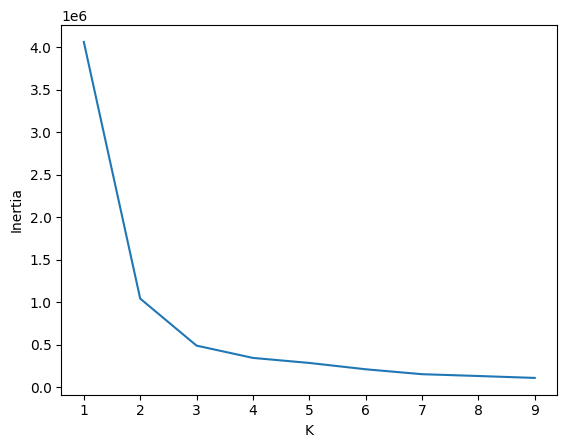

In [65]:
coordinates = df[["Latitude","Longitude"]].values
k_values = range(1,10)
inertia_values = []
for k in k_values:
    inertia_values.append(KMeans(k).fit(coordinates).inertia_)

plt.plot(range(1,10), inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

The "elbow" method in elbow plot points to a K of 3. That value limits our scope to at most three different geographic territories.  
We will still cluster the locations into three groups and plot them on a map

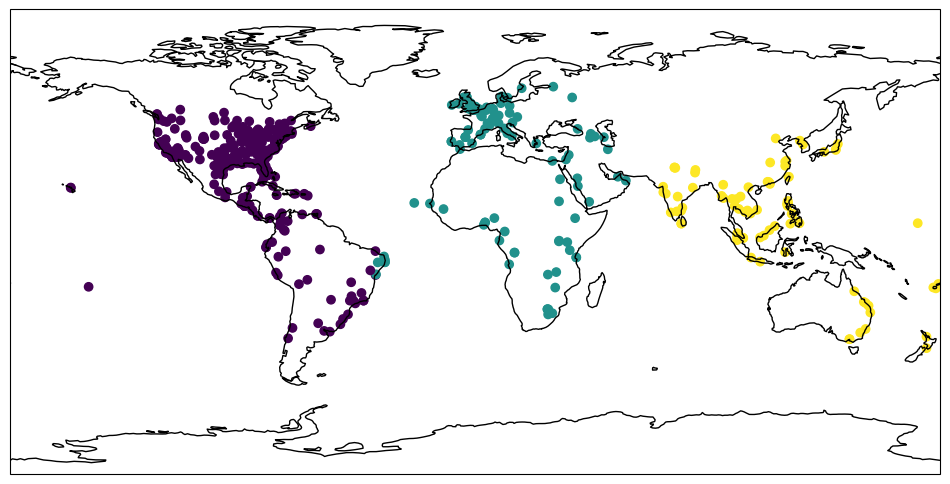

In [66]:
def plot_clusters(clusters, longitudes, latitudes):
    plt.figure(figsize=(12,10))
    ax = plt.axes(projection=PlateCarree())
    ax.coastlines()
    ax.scatter(longitudes, latitudes,c=clusters)
    ax.set_global()
    plt.show()

df['Cluster'] = KMeans(3).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

These clusters are not helpful for understanding data. 

Let's increase K size to 6

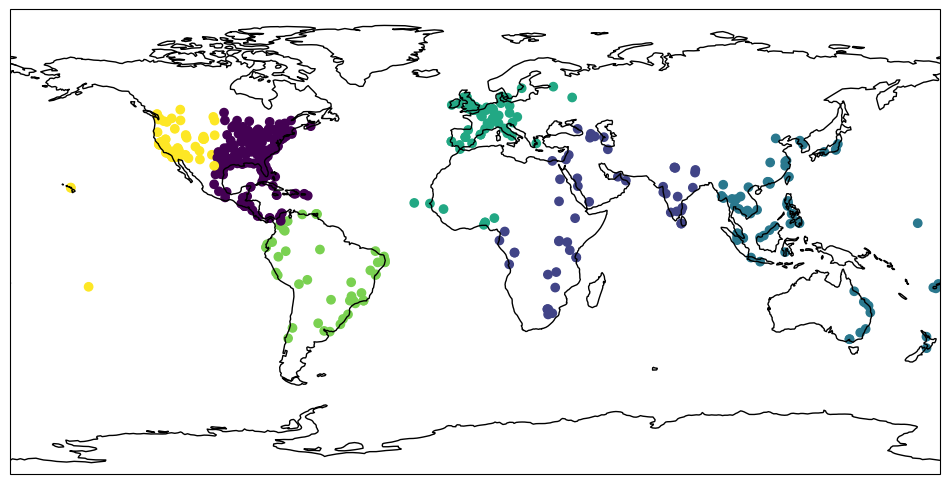

In [68]:
df['Cluster'] = KMeans(6).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

Increasing K improves clustering in North America and South America.  
  
However, Africa's geolocations are incorrectly split betwee Europe and Asia.  
  
Perhaps the algorithm's reliance on Euclidean distance prevents it from capturing relationships between points distributed on planets curved surface.

#### 2.1 - DBSCAN algorithm

It is an alternate approach that takes as input any distance metric of our choosing, allowing us to cluster on the great-circle distance between points

In [75]:
def great_circle_distance(coord1, coord2, radius=3956):
    if np.array_equal(coord1, coord2):
        return 0.0
    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    delta_x, delta_y = coord2 - coord1
    haversin = sin(delta_x / 2) ** 2 + np.prod([cos(coord1[0]),
                                                   cos(coord2[0]),
                                                   sin(delta_y / 2) ** 2])
    return 2 * radius * asin(haversin ** 0.5)

Let's assume the following: a global city cluster contains at least three cities that are on average no more than 250 miles apart. 
  
Based on these assumptions, we input values from 250 and 3 into eps and mins_samples parameters in DBSCAN function.  



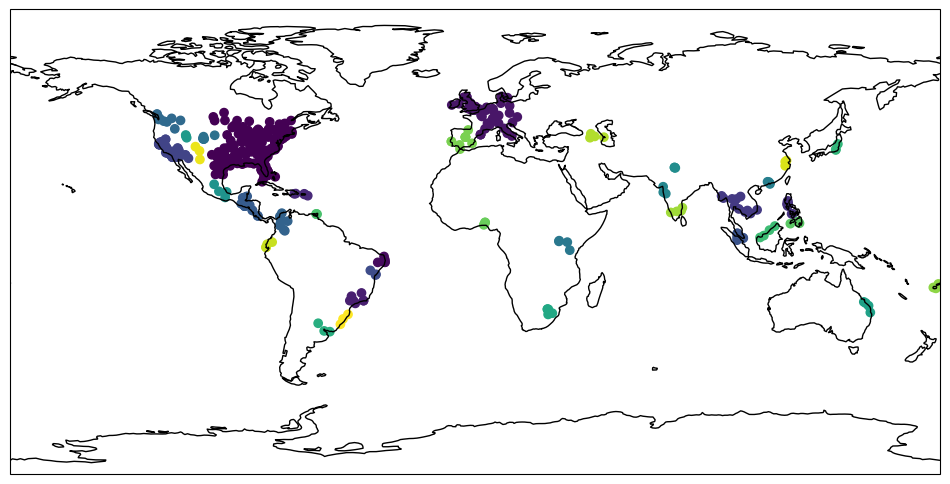

In [77]:
metric = great_circle_distance
dbscan = DBSCAN(eps=250, min_samples=3, metric=metric)
df['Cluster'] = dbscan.fit_predict(coordinates)
# DBSCAN assigns -1 to outlier data points that don't cluster.

df_no_outliers = df[df.Cluster > -1]
plot_clusters(df_no_outliers.Cluster, df_no_outliers.Longitude, df_no_outliers.Latitude)


DBSCAN has done a decent job generating discrete clusters in parts of South America, Asia and southern Africa.  
The eastern US falls into a single overly dense cluster. Why is this a case?  
  
  
More likely events in America get more coverage.  
One way to overcome the geographic bias is to recluster US cities using a more rigorous epsilon parameter.  
So we will cluster US locations independently from the rest of the world.

In [78]:
# let's first assign country codes across each of our cities.
def get_country_code(city_name):
    city = max(gc.get_cities_by_name(city_name), 
               key=lambda x: list(x.values())[0]['population'])
    return list(city.values())[0]['countrycode']
df["Country_code"] = df.City.apply(get_country_code)


In [80]:
df_us = df[df.Country_code == 'US']
df_not_us = df[df.Country_code != 'US']

We separated US and Non US cities. Now we need to recluster the coordincates in two separated tables.

We maintain eps of 250 in not_us table, however, we will reduce eps for df_us by half to acknowledge the tighter density in the US.
